In [0]:

# =========================================
# 1. Завантаження даних RetailRocket
# =========================================
from pyspark.sql.functions import col

delta_path = "/Volumes/workspace/default/retail_delta_3"
retail_df = spark.read.format("delta").load(delta_path)

print("Rows (всі події):", retail_df.count())
display(retail_df.limit(5))


Rows (всі події): 17672


transactionid,event_indexed_mean,itemid_index_mean,year_mean,month_mean,day_mean,weekday_mean,event_indexed_sq,event_item_interaction,month_ratio,high_event_indexed,event_indexed_diff_avg,numeric_vector_scaled,numeric_scaled_features,pca_features,umap_1,umap_2
17149,2.0,0.0,2015.0,6.0,15.0,2.0,4.0,0.0,0.5,1,1.1174559547955099E-4,"{""type"":""1"",""size"":null,""indices"":null,""values"":[""2.0"",""0.0"",""2015.0"",""6.0"",""15.0"",""2.0"",""4.0"",""0.0"",""0.5"",""1.0"",""1.1174559547955099E-4""]}","{""type"":""1"",""size"":null,""indices"":null,""values"":[""0.007522412565335041"",""-0.08381900267045671"",""0.0"",""-0.6024630586008568"",""-0.05851539682216944"",""-1.0582415028979817"",""0.007522412565750134"",""-0.0838140871893417"",""-0.6024630586008395"",""0.007522412565814542"",""0.007522412565814344""]}","{""type"":""1"",""size"":null,""indices"":null,""values"":[""-0.01516182600273725"",""0.7667818374593217"",""0.3655262519513802"",""-1.0455972401771176"",""0.22007289816067027""]}",9.353109,12.3478775
12914,2.0,0.0,2015.0,6.0,17.0,4.0,4.0,0.0,0.5,1,1.1174559547955099E-4,"{""type"":""1"",""size"":null,""indices"":null,""values"":[""2.0"",""0.0"",""2015.0"",""6.0"",""17.0"",""4.0"",""4.0"",""0.0"",""0.5"",""1.0"",""1.1174559547955099E-4""]}","{""type"":""1"",""size"":null,""indices"":null,""values"":[""0.007522412565335041"",""-0.08381900267045671"",""0.0"",""-0.6024630586008568"",""0.1706346359359646"",""0.08093508889295811"",""0.007522412565750134"",""-0.0838140871893417"",""-0.6024630586008395"",""0.007522412565814542"",""0.007522412565814344""]}","{""type"":""1"",""size"":null,""indices"":null,""values"":[""-0.014994823255414189"",""0.7834857545699627"",""0.39010678869821797"",""0.09726433820460328"",""0.012185414331564916""]}",-10.791374,0.6767426
4366,2.0,0.0,2015.0,6.0,23.0,3.0,4.0,0.0,0.5,1,1.1174559547955099E-4,"{""type"":""1"",""size"":null,""indices"":null,""values"":[""2.0"",""0.0"",""2015.0"",""6.0"",""23.0"",""3.0"",""4.0"",""0.0"",""0.5"",""1.0"",""1.1174559547955099E-4""]}","{""type"":""1"",""size"":null,""indices"":null,""values"":[""0.007522412565335041"",""-0.08381900267045671"",""0.0"",""-0.6024630586008568"",""0.8580847342103667"",""-0.4886532070025118"",""0.007522412565750134"",""-0.0838140871893417"",""-0.6024630586008395"",""0.007522412565814542"",""0.007522412565814344""]}","{""type"":""1"",""size"":null,""indices"":null,""values"":[""-0.015132418171252177"",""0.9160153662801979"",""0.4666520818575631"",""-0.460011244331769"",""-0.6682843430640595""]}",15.877406,7.5837975
1021,2.0,0.0,2015.0,6.0,29.0,2.0,4.0,0.0,0.5,1,1.1174559547955099E-4,"{""type"":""1"",""size"":null,""indices"":null,""values"":[""2.0"",""0.0"",""2015.0"",""6.0"",""29.0"",""2.0"",""4.0"",""0.0"",""0.5"",""1.0"",""1.1174559547955099E-4""]}","{""type"":""1"",""size"":null,""indices"":null,""values"":[""0.007522412565335041"",""-0.08381900267045671"",""0.0"",""-0.6024630586008568"",""1.5455348324847689"",""-1.0582415028979817"",""0.007522412565750134"",""-0.0838140871893417"",""-0.6024630586008395"",""0.007522412565814542"",""0.007522412565814344""]}","{""type"":""1"",""size"":null,""indices"":null,""values"":[""-0.015270013087090166"",""1.048544977990433"",""0.5431973750169081"",""-1.0172868268681412"",""-1.3487541004596846""]}",10.220147,-10.007038
2737,2.0,0.0,2015.0,6.0,21.0,1.0,4.0,0.0,0.5,1,1.1174559547955099E-4,"{""type"":""1"",""size"":null,""indices"":null,""values"":[""2.0"",""0.0"",""2015.0"",""6.0"",""21.0"",""1.0"",""4.0"",""0.0"",""0.5"",""1.0"",""1.1174559547955099E-4""]}","{""type"":""1"",""size"":null,""indices"":null,""values"":[""0.007522412565335041"",""-0.08381900267045671"",""0.0"",""-0.6024630586008568"",""0.6289347014522326"",""-1.6278297987934516"",""0.007522412565750134"",""-0.0838140871893417"",""-0.6024630586008395"",""0.007522412565814542"",""0.007522412565814344""]}","{""type"":""1"",""size"":null,""indices"":null,""values"":[""-0.015299420918575236"",""0.8993114491695569"",""0.4420715451107253"",""-1.

In [0]:
# =========================================
# 2. Фільтрація addtocart / transaction
# =========================================

filtered_df = retail_df.filter(col("event").isin("addtocart", "transaction"))
filtered_df = filtered_df.withColumn("is_purchase", (col("event") == "transaction").cast("int"))

# =========================================
# 3. Вибір ознак
# =========================================

feature_cols_rr = [
    "event_indexed",
    "year", "month", "day",
    "weekday", "weekofyear",
    "visitorid",
    "itemid"
]

target_col_rr = "is_purchase"

# очищення від NULL
for c in feature_cols_rr + [target_col_rr]:
    filtered_df = filtered_df.filter(col(c).isNotNull())

In [0]:
# =========================================
# 4. ПЕРЕХІД У PANDAS 
# =========================================
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from pyspark.sql.functions import col

# 1. Вибираємо ознаки, які Spark точно бачить 
feature_cols_rr = [
    "itemid_index_mean", 
    "day_mean", 
    "weekday_mean", 
    "year_mean"
]

# 2. Створюємо цільову змінну на основі month_ratio
# Оскільки month_ratio = month/12, значення > 0.5 означають липень-грудень
retail_df = retail_df.withColumn("target_binary", (col("month_ratio") > 0.5).cast("int"))

target_col_rr = "target_binary"

# 3. Видаляємо NULL та переходимо в Pandas
pdf_rr = retail_df.select(feature_cols_rr + [target_col_rr]).dropna().toPandas()

# Перевірка розподілу класів
counts = pdf_rr[target_col_rr].value_counts()
print("Розподіл класів для target_binary:")
print(counts)

# Перевірка: якщо один з класів має < 2 значень, видаляємо його
if len(counts) < 2 or counts.min() < 2:
    print("Попередження: занадто мало даних для одного з класів. Використовуємо спрощене розбиття.")
    stratify_param = None
else:
    stratify_param = pdf_rr[target_col_rr].values

# 4. Підготовка масивів
X_rr = pdf_rr[feature_cols_rr].values
y_rr = pdf_rr[target_col_rr].values.astype(int)

# 5. Розбиття даних
X_train_rr, X_temp_rr, y_train_rr, y_temp_rr = train_test_split(
    X_rr, y_rr, 
    test_size=0.30, 
    random_state=42, 
    stratify=stratify_param
)

X_val_rr, X_test_rr, y_val_rr, y_test_rr = train_test_split(
    X_temp_rr, y_temp_rr, 
    test_size=0.50, 
    random_state=42, 
    stratify=y_temp_rr if stratify_param is not None else None
)

print(f"Дані готові! Train size: {X_train_rr.shape[0]}")

Розподіл класів для target_binary:
target_binary
1    9949
0    7723
Name: count, dtype: int64
Дані готові! Train size: 12370


In [0]:

# =========================================
# 6. Масштабування
# =========================================
from sklearn.preprocessing import StandardScaler

scaler_rr = StandardScaler()
X_train_rr_scaled = scaler_rr.fit_transform(X_train_rr)
X_val_rr_scaled   = scaler_rr.transform(X_val_rr)
X_test_rr_scaled  = scaler_rr.transform(X_test_rr)

# =========================================
# 7. Підбір гіперпараметрів RandomForest на TRAIN
# =========================================
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

param_grid_rr = {
    "n_estimators": [100, 200],
    "max_depth": [8, 12, 16],
    "min_samples_split": [2, 5]
}

grid_rr = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42, n_jobs=-1),
    param_grid=param_grid_rr,
    scoring="roc_auc",
    cv=3,
    n_jobs=-1,
    verbose=1
)

grid_rr.fit(X_train_rr, y_train_rr)

print("Найкращі параметри:", grid_rr.best_params_)

best_rf_rr = grid_rr.best_estimator_

Fitting 3 folds for each of 12 candidates, totalling 36 fits
Найкращі параметри: {'max_depth': 16, 'min_samples_split': 2, 'n_estimators': 200}


In [0]:
# =========================================
# 8. Тренування моделей (на TRAIN) + оцінка на TEST
# =========================================
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

metrics = []

# Logistic Regression
lr = LogisticRegression(max_iter=1000, class_weight="balanced")
lr.fit(X_train_rr_scaled, y_train_rr)

y_pred_lr = lr.predict(X_test_rr_scaled)
y_proba_lr = lr.predict_proba(X_test_rr_scaled)[:, 1]

metrics.append(("Logistic Regression",
                accuracy_score(y_test_rr, y_pred_lr),
                f1_score(y_test_rr, y_pred_lr),
                roc_auc_score(y_test_rr, y_proba_lr)))

# Decision Tree
dt = DecisionTreeClassifier(max_depth=10, random_state=42)
dt.fit(X_train_rr, y_train_rr)

y_pred_dt = dt.predict(X_test_rr)
y_proba_dt = dt.predict_proba(X_test_rr)[:, 1]

metrics.append(("Decision Tree",
                accuracy_score(y_test_rr, y_pred_dt),
                f1_score(y_test_rr, y_pred_dt),
                roc_auc_score(y_test_rr, y_proba_dt)))

# Random Forest (tuned)
rf = best_rf_rr
rf.fit(X_train_rr, y_train_rr)

y_pred_rf = rf.predict(X_test_rr)
y_proba_rf = rf.predict_proba(X_test_rr)[:, 1]

metrics.append(("Random Forest (tuned)",
                accuracy_score(y_test_rr, y_pred_rf),
                f1_score(y_test_rr, y_pred_rf),
                roc_auc_score(y_test_rr, y_proba_rf)))

# Gradient Boosting
gbr = GradientBoostingClassifier(
    n_estimators=200, learning_rate=0.05, max_depth=3, random_state=42
)
gbr.fit(X_train_rr, y_train_rr)

y_pred_gbr = gbr.predict(X_test_rr)
y_proba_gbr = gbr.predict_proba(X_test_rr)[:, 1]

metrics.append(("Gradient Boosting",
                accuracy_score(y_test_rr, y_pred_gbr),
                f1_score(y_test_rr, y_pred_gbr),
                roc_auc_score(y_test_rr, y_proba_gbr)))


# =========================================
# 9. РЕЗУЛЬТАТИ
# =========================================
results_rr = pd.DataFrame(metrics, columns=["Model", "Accuracy", "F1-score", "ROC-AUC"])
display(results_rr)            

Model,Accuracy,F1-score,ROC-AUC
Logistic Regression,0.5198038476046775,0.5438910784664994,0.536925148100771
Decision Tree,0.9192757450018861,0.930699481865285,0.9843230620831954
Random Forest (tuned),0.996982270841192,0.9973262032085561,0.9999788923149522
Gradient Boosting,0.7389664277631083,0.7846919726197884,0.8153349355897546


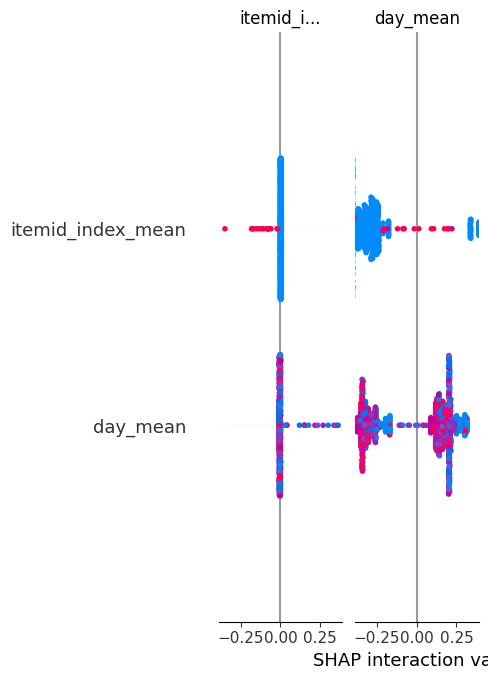

In [0]:


# =========================================
# 10. SHAP — інтерпретація
# =========================================

import shap
shap.initjs()

X_sample_rr = X_test_rr[:1500]  # оптимально

explainer_rr = shap.TreeExplainer(rf)
shap_values_rr = explainer_rr.shap_values(X_sample_rr)

if isinstance(shap_values_rr, list):
    shap_vals_class1_rr = shap_values_rr[1]
else:
    shap_vals_class1_rr = shap_values_rr

shap.summary_plot(
    shap_vals_class1_rr,
    X_sample_rr,
    feature_names=feature_cols_rr
)


In [0]:
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

def compute_metrics(model, X_train, y_train, X_val, y_val, X_test, y_test, scaled=False, scaler=None):
    if scaled:
        X_train = scaler.transform(X_train)
        X_val   = scaler.transform(X_val)
        X_test  = scaler.transform(X_test)

    # Прогнози
    pred_train = model.predict(X_train)
    pred_val   = model.predict(X_val)
    pred_test  = model.predict(X_test)

    proba_train = model.predict_proba(X_train)[:,1]
    proba_val   = model.predict_proba(X_val)[:,1]
    proba_test  = model.predict_proba(X_test)[:,1]

    return [
        accuracy_score(y_train, pred_train),
        f1_score(y_train, pred_train),
        roc_auc_score(y_train, proba_train),

        accuracy_score(y_val, pred_val),
        f1_score(y_val, pred_val),
        roc_auc_score(y_val, proba_val),

        accuracy_score(y_test, pred_test),
        f1_score(y_test, pred_test),
        roc_auc_score(y_test, proba_test),
    ]


results_full = []

results_full.append(
    ["Logistic Regression"] + compute_metrics(
        lr,
        X_train_rr, y_train_rr,
        X_val_rr, y_val_rr,
        X_test_rr, y_test_rr,
        scaled=True, scaler=scaler_rr
    )
)

results_full.append(
    ["Decision Tree"] + compute_metrics(
        dt,
        X_train_rr, y_train_rr,
        X_val_rr, y_val_rr,
        X_test_rr, y_test_rr,
        scaled=False
    )
)

results_full.append(
    ["Random Forest (tuned)"] + compute_metrics(
        rf,
        X_train_rr, y_train_rr,
        X_val_rr, y_val_rr,
        X_test_rr, y_test_rr,
        scaled=False
    )
)

results_full.append(
    ["Gradient Boosting"] + compute_metrics(
        gbr,
        X_train_rr, y_train_rr,
        X_val_rr, y_val_rr,
        X_test_rr, y_test_rr,
        scaled=False
    )
)

columns = [
    "Model",
    "Train_Accuracy", "Train_F1", "Train_ROC-AUC",
    "Val_Accuracy",   "Val_F1",   "Val_ROC-AUC",
    "Test_Accuracy",  "Test_F1",  "Test_ROC-AUC"
]

import pandas as pd
df_results_full = pd.DataFrame(results_full, columns=columns)
display(df_results_full)

Model,Train_Accuracy,Train_F1,Train_ROC-AUC,Val_Accuracy,Val_F1,Val_ROC-AUC,Test_Accuracy,Test_F1,Test_ROC-AUC
Logistic Regression,0.5244947453516572,0.549202942979767,0.542167099844175,0.5250848736325915,0.5498748659277798,0.5462613670936449,0.5198038476046775,0.5438910784664994,0.536925148100771
Decision Tree,0.919482619240097,0.9309196837286725,0.9841371049845058,0.9128630705394191,0.925459825750242,0.9821599820463256,0.9192757450018861,0.930699481865285,0.9843230620831954
Random Forest (tuned),1.0,1.0,1.0,0.998491135420596,0.9986622073578595,0.9999901671241845,0.996982270841192,0.9973262032085561,0.9999788923149522
Gradient Boosting,0.7434114793856104,0.7879476215927311,0.8164030733184542,0.7363259147491512,0.7865648854961832,0.8165451438896774,0.7389664277631083,0.7846919726197884,0.8153349355897546


In [0]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    accuracy_score, f1_score, roc_auc_score,
    precision_score, recall_score,
    roc_curve, precision_recall_curve,
    confusion_matrix
)
import numpy as np
import shap

# -----------------------------------------
# 1. ДОДАТКОВІ МЕТРИКИ
# -----------------------------------------

print("="*60)
print("  FULL METRICS FOR BEST MODEL (Random Forest)")
print("="*60)

print("Accuracy:", accuracy_score(y_test_rr, y_pred_rf))
print("Precision:", precision_score(y_test_rr, y_pred_rf))
print("Recall:", recall_score(y_test_rr, y_pred_rf))
print("F1-score:", f1_score(y_test_rr, y_pred_rf))
print("ROC-AUC:", roc_auc_score(y_test_rr, y_proba_rf))



  FULL METRICS FOR BEST MODEL (Random Forest)
Accuracy: 0.996982270841192
Precision: 0.9946666666666667
Recall: 1.0
F1-score: 0.9973262032085561
ROC-AUC: 0.9999788923149522


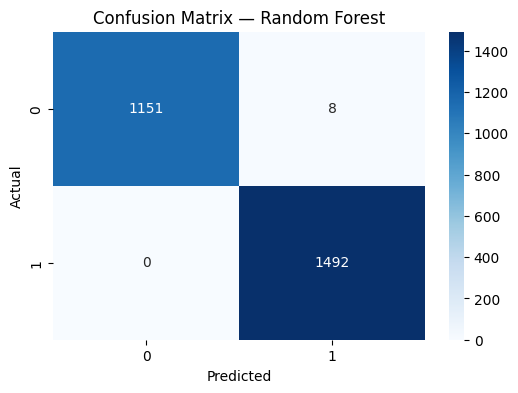

In [0]:
# -----------------------------------------
# 2. CONFUSION MATRIX
# -----------------------------------------

cm = confusion_matrix(y_test_rr, y_pred_rf)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix — Random Forest")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


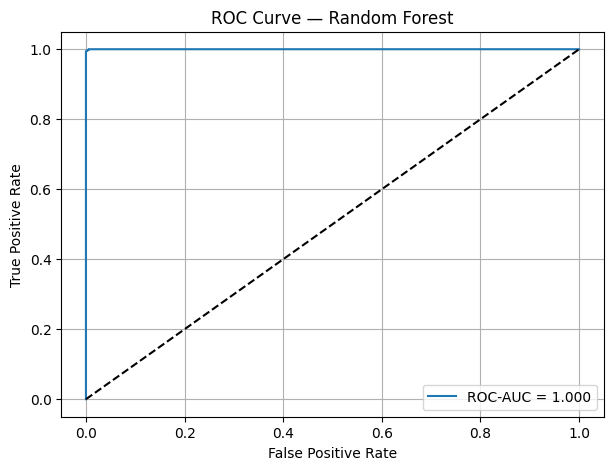

In [0]:

# -----------------------------------------
# 3. ROC CURVE
# -----------------------------------------

fpr, tpr, _ = roc_curve(y_test_rr, y_proba_rf)

plt.figure(figsize=(7,5))
plt.plot(fpr, tpr, label=f"ROC-AUC = {roc_auc_score(y_test_rr, y_proba_rf):.3f}")
plt.plot([0,1], [0,1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve — Random Forest")
plt.legend()
plt.grid(True)
plt.show()



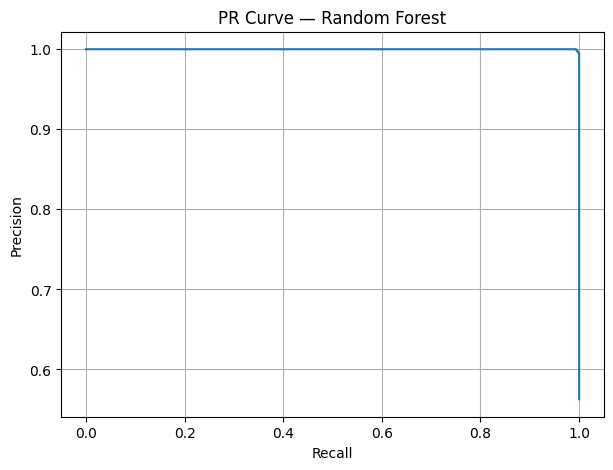

In [0]:
# -----------------------------------------
# 4. PRECISION–RECALL CURVE
# -----------------------------------------

prec, rec, _ = precision_recall_curve(y_test_rr, y_proba_rf)

plt.figure(figsize=(7,5))
plt.plot(rec, prec, label="Precision-Recall curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("PR Curve — Random Forest")
plt.grid(True)
plt.show()


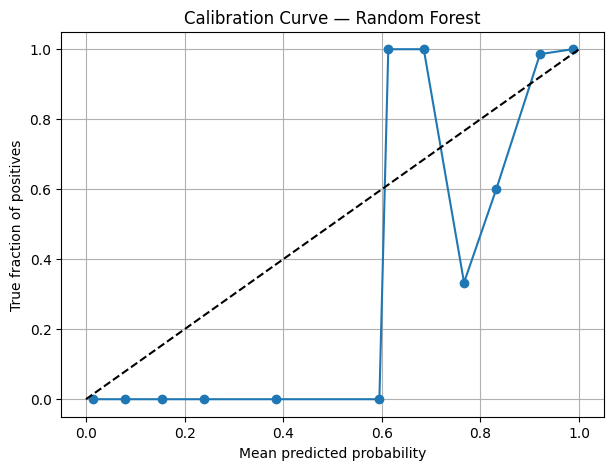

In [0]:

# -----------------------------------------
# 5. CALIBRATION CURVE
# -----------------------------------------

from sklearn.calibration import calibration_curve

prob_true, prob_pred = calibration_curve(y_test_rr, y_proba_rf, n_bins=15)

plt.figure(figsize=(7,5))
plt.plot(prob_pred, prob_true, marker='o')
plt.plot([0,1], [0,1], 'k--')
plt.xlabel("Mean predicted probability")
plt.ylabel("True fraction of positives")
plt.title("Calibration Curve — Random Forest")
plt.grid(True)
plt.show()



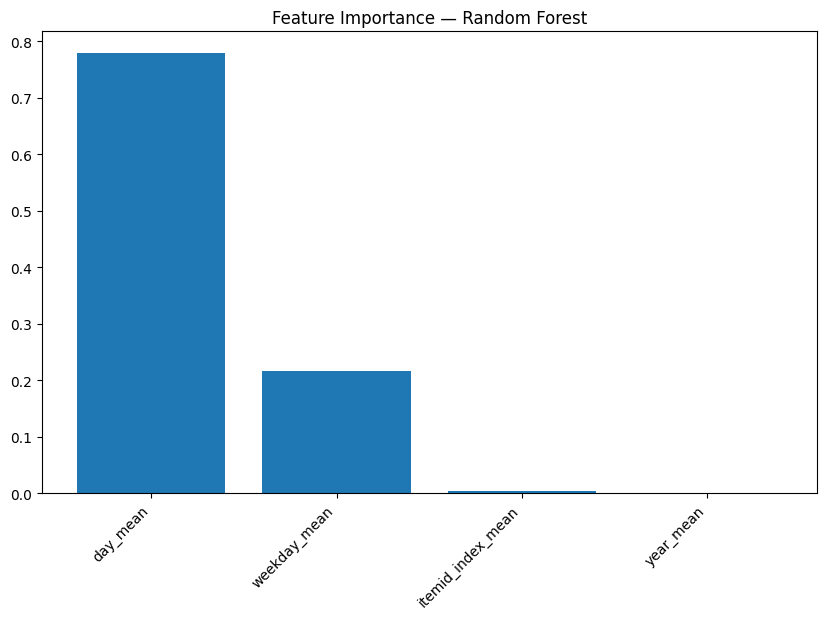

In [0]:
# -----------------------------------------
# 6. FEATURE IMPORTANCE
# -----------------------------------------

importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10,6))
plt.bar(range(len(feature_cols_rr)), importances[indices])
plt.xticks(range(len(feature_cols_rr)),
           [feature_cols_rr[i] for i in indices],
           rotation=45, ha='right')
plt.title("Feature Importance — Random Forest")
plt.show()


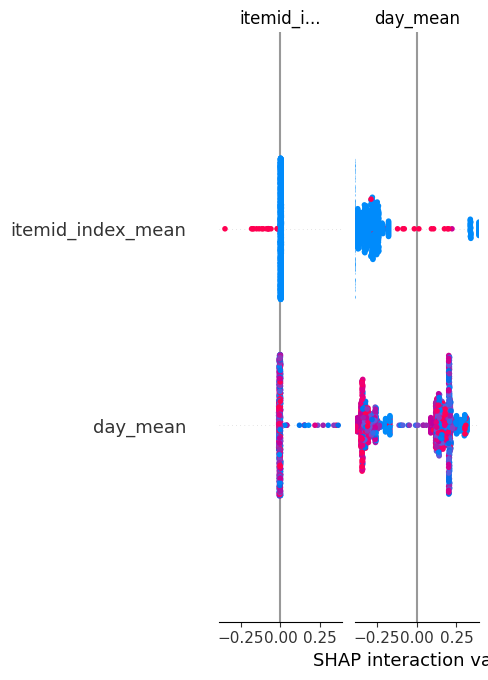

In [0]:

# -----------------------------------------
# 7. SHAP summary (поглиблена інтерпретація)
# -----------------------------------------

shap.initjs()
X_sample_rr = X_test_rr[:1500]

explainer_rr = shap.TreeExplainer(rf)
shap_values_rr = explainer_rr.shap_values(X_sample_rr)

shap_vals_class1_rr = shap_values_rr[1] if isinstance(shap_values_rr, list) else shap_values_rr

shap.summary_plot(
    shap_vals_class1_rr,
    X_sample_rr,
    feature_names=feature_cols_rr
)